In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import os
import numpy as np

In [4]:
import tensorflow as tf
import tensorflow_hub as hub

In [19]:
from keras import backend as K
from keras.models import Model, Input, load_model
from keras.layers import Dense, Lambda, Activation, Conv1D, MaxPooling1D, Flatten, Reshape
from keras.optimizers import RMSprop, Adam, Adamax, SGD
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2
from keras.layers.merge import add
from keras.utils import to_categorical

In [3]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score as scikit_f1_score

#### Custom Functions

In [20]:
from src.callbacks import PlotCurves
from src.eval_metrics import f1_macro, f1_micro
from src.load_data import load_data

### Load Data

In [7]:
train_data, valid_data, test_data, metadata = load_data()

### Prepare data

In [8]:
n_tags = 2
batch_size = 32

In [9]:
def get_contextual_sentences(data_, ww):

    X = []
    for article in data_:
        sent_list = article['sentences']
        for i, sentence in enumerate(sent_list):
            merged_sents = [sent_list[i]['sentence'].replace('\n', '').strip()]
            for w in range(1, ww+1):
                if i - w >= 0:
                    merged_sents = [sent_list[i-w]['sentence'].replace('\n', '').strip()] + merged_sents
                if i + w < len(sent_list):
                    merged_sents.append(sent_list[i+w]['sentence'].replace('\n', '').strip())
            X.append(' '.join(merged_sents))

    return np.array(X)

In [10]:
def get_y(data_, to_categorize):

    y = np.array([sentence['label'] for article in data_ for sentence in article['sentences']])
    if to_categorize:
        y = to_categorical(y)
    
    return y

In [72]:
# sliding window width = ww*prev + curr + ww*next
ww = 5

In [73]:
X_tra = get_contextual_sentences(train_data, ww)
X_val = get_contextual_sentences(valid_data, ww)
X_test = get_contextual_sentences(test_data, ww)

In [74]:
len(X_tra[0])

1187

In [75]:
y_tra = get_y(train_data, True)
y_val = get_y(valid_data, True)
y_test = get_y(test_data, False)

### Load ELMo

In [76]:
sess = tf.Session()
K.set_session(sess)

In [77]:
elmo = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

## Build Model

In [78]:
def ELMoEmbedding(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [79]:
def build_model_1():
    
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024,))(input_text)
    
    x = Dense(256, kernel_regularizer=l2(0.001))(embedding)
    x = Activation('relu')(x)
    
    x = Dense(128, kernel_regularizer=l2(0.001))(x)
    x = Activation('relu')(x)
    
    pred = Dense(2, activation='sigmoid')(x)

    return Model(inputs=[input_text], outputs=pred)

In [80]:
learningrate=0.001
optimizer = Adam(lr=learningrate)
optimizer_str = 'adam'
loss = 'binary_crossentropy'
metrics = ['acc', f1_macro, f1_micro]

In [81]:
model = build_model_1()
model.summary()

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_5 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               262400    
_________________________________________________________________
activation_9 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
activation_10 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 258       
Total para

In [82]:
model_name = 'RQ1_test_elmo_contextual_model_1' + \
             '_ww_' + str(ww) + \
             '_' + optimizer_str +  \
             '_lr_' + str(learningrate) +  \
             '_lrreduction' + \
             '_loss_' + loss

model_dir = './Model/Contextual/' + model_name.split('model')[0] + 'model/' + model_name
results_file = os.path.join(model_dir, 'model_results_file.txt')

### Train

In [ ]:
## Flat Model Fit ww=1
model.fit(X_tra, y_tra, 
          epochs=50, 
          batch_size=batch_size, 
          validation_data=(X_val, y_val), 
          callbacks=[
              PlotCurves(model_name=model_name, model_dir=model_dir, jnote=True),
              ReduceLROnPlateau(monitor='val_f1_macro', patience=5, 
                                factor=0.1, min_lr=0.00001),
              EarlyStopping(monitor='val_f1_macro', min_delta=0, patience=10, mode='max')
          ])

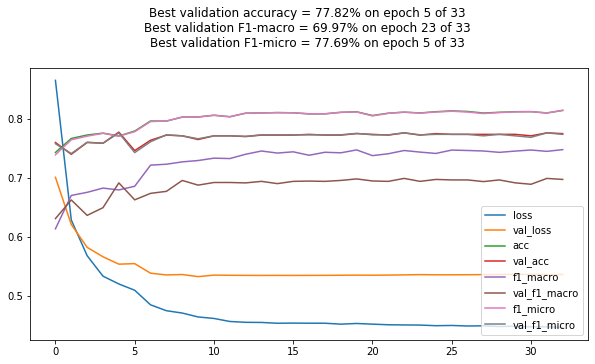

In [52]:
## Flat Model Fit ww=2
model.fit(X_tra, y_tra, 
          epochs=50, 
          batch_size=batch_size, 
          validation_data=(X_val, y_val), 
          callbacks=[
              PlotCurves(model_name=model_name, model_dir=model_dir, jnote=True),
              ReduceLROnPlateau(monitor='val_f1_macro', patience=5, 
                                factor=0.1, min_lr=0.00001),
              EarlyStopping(monitor='val_f1_macro', min_delta=0, patience=10, mode='max')
          ])

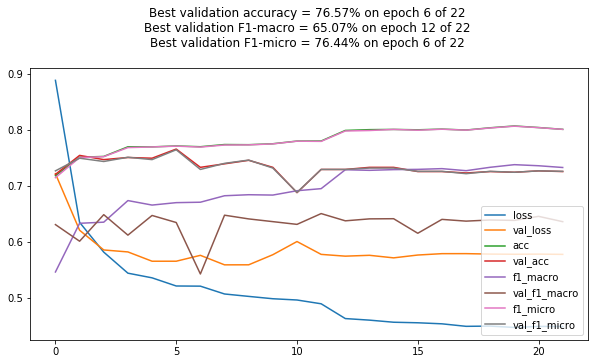

In [68]:
## Flat Model Fit ww=3
model.fit(X_tra, y_tra, 
          epochs=50, 
          batch_size=batch_size, 
          validation_data=(X_val, y_val), 
          callbacks=[
              PlotCurves(model_name=model_name, model_dir=model_dir, jnote=True),
              ReduceLROnPlateau(monitor='val_f1_macro', patience=5, 
                                factor=0.1, min_lr=0.00001),
              EarlyStopping(monitor='val_f1_macro', min_delta=0, patience=10, mode='max')
          ])

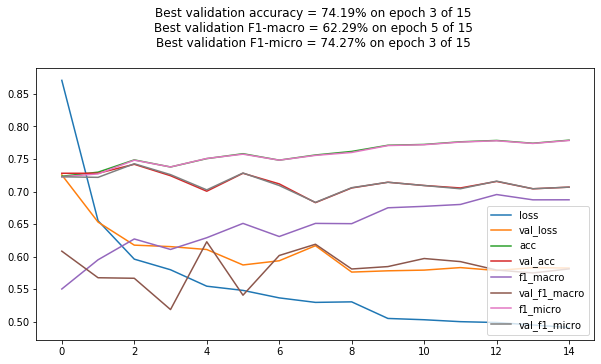

In [83]:
## Flat Model Fit ww=5
model.fit(X_tra, y_tra, 
          epochs=50, 
          batch_size=batch_size, 
          validation_data=(X_val, y_val), 
          callbacks=[
              PlotCurves(model_name=model_name, model_dir=model_dir, jnote=True),
              ReduceLROnPlateau(monitor='val_f1_macro', patience=5, 
                                factor=0.1, min_lr=0.00001),
              EarlyStopping(monitor='val_f1_macro', min_delta=0, patience=10, mode='max')
          ])

### Test

In [84]:
y_preds = model.predict(X_test, batch_size=batch_size)

In [85]:
y_preds = np.argmax(y_preds, axis=1)

In [40]:
### build_flat_model_1 results ww=1
print(classification_report(y_test, y_preds)) 

              precision    recall  f1-score   support

           0       0.83      0.91      0.87       325
           1       0.65      0.47      0.55       116

   micro avg       0.80      0.80      0.80       441
   macro avg       0.74      0.69      0.71       441
weighted avg       0.78      0.80      0.78       441



In [56]:
### build_flat_model_1 results ww=2
print(classification_report(y_test, y_preds)) 

              precision    recall  f1-score   support

           0       0.78      0.94      0.86       325
           1       0.63      0.28      0.38       116

   micro avg       0.77      0.77      0.77       441
   macro avg       0.71      0.61      0.62       441
weighted avg       0.74      0.77      0.73       441



In [71]:
### build_flat_model_1 results ww=3
print(classification_report(y_test, y_preds)) 

              precision    recall  f1-score   support

           0       0.78      0.94      0.86       325
           1       0.63      0.28      0.38       116

   micro avg       0.77      0.77      0.77       441
   macro avg       0.71      0.61      0.62       441
weighted avg       0.74      0.77      0.73       441



In [86]:
### build_flat_model_1 results ww=5
print(classification_report(y_test, y_preds)) 

              precision    recall  f1-score   support

           0       0.78      0.94      0.85       325
           1       0.62      0.28      0.38       116

   micro avg       0.76      0.76      0.76       441
   macro avg       0.70      0.61      0.62       441
weighted avg       0.74      0.76      0.73       441

